In [1]:
import os
import pandas as pd
from tqdm import tqdm
from glob import glob
from dotenv import load_dotenv
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from experiment_4.dataset import AEDataset
from experiment_4.model import Detector
from utils.s3_download import list_all_objects, s3_client
from pathlib import Path
from PIL import Image
from multiprocessing import Pool


load_dotenv(override=True)

LOCAL_BUCKET_FOLDER = os.getenv("LOCAL_BUCKET_FOLDER")
EXPERIMENT_FOLDER = "experiment_4"

device = "cuda:0"
dtype = torch.bfloat16

/home/teekh/workspace/git_personal/image-detection-model-experiments/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BUCKET_NAME = os.getenv("BUCKET_NAME")
LOCAL_BUCKET_FOLDER = os.getenv("LOCAL_BUCKET_FOLDER")
SELECTED_FOLDER = os.getenv("SELECTED_FOLDER")
IMAGE_SIZE = eval(os.getenv("IMAGE_SIZE"))

selected_date = '2023-11-27T16-02-52'

def list_files_to_download(s3_folder:str):
    s3_files = list_all_objects(s3_client, BUCKET_NAME, s3_folder)
    print(f"Number of files in {BUCKET_NAME}/{s3_folder}: {len(s3_files)}")
    s3_files = [k['Key'] for k in s3_files if not k['Key'].endswith('/')]
    return s3_files

prefix_ignore = [
    'VW5pZGVudGlmaWVkPE82a0RqPmJib3ggbm90IGNsZWFuZWQ8TzZrRGo-eWVsbG93IG5hcnJvdyB0cmlhbmdsZSB3aXJlIGhvbGRlcg==',
    'VW5pZGVudGlmaWVkPE82a0RqPmJib3ggbm90IGNsZWFuZWQ8TzZrRGo-Z3JleSBib3g=',
]
s3_files = list_files_to_download(f"{SELECTED_FOLDER}/{selected_date}")
s3_files = [f for f in s3_files if f.split('/')[2] not in prefix_ignore]
print(f"Number of files for training (includes jpg and json): {len(s3_files)}")

listing s3 objects: 0it [00:00, ?it/s]

listing s3 objects: 3it [00:02,  1.22it/s]

Number of files in sg-implement/prod_selected/2023-11-27T16-02-52: 2472
Number of files for training (includes jpg and json): 2072


In [3]:
def download_and_resize(file:str, s3_client=s3_client):
    local_save_folder = Path(f"{EXPERIMENT_FOLDER}")
    local_img_path = local_save_folder / file
    if local_img_path.exists():
        return False
    local_img_path.parent.mkdir(parents=True, exist_ok=True)
    s3_client.download_file(BUCKET_NAME, file, str(local_img_path))
    if local_img_path.suffix == '.jpg':
        img = Image.open(local_img_path)
        img.save(local_img_path)
    return True

def download_images(s3_files:list[str]):
    with Pool(16) as p:
        r = list(tqdm(p.imap(download_and_resize, s3_files), total=len(s3_files)))
    num_downloaded = sum(r)
    print(f"Number of files downloaded: {num_downloaded}")
    return num_downloaded

num_downloaded = download_images(s3_files)

100%|██████████| 2072/2072 [00:00<00:00, 11116.99it/s]

Number of files downloaded: 0


In [4]:
import os
import pandas as pd
from tqdm import tqdm
from glob import glob
from dotenv import load_dotenv
import torch
from torch import optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from base64 import urlsafe_b64decode
from random import sample
from PIL import Image
import json


load_dotenv(override=True)

tqdm.pandas()

def get_image_name(image_path, offset:int):
    return '/'.join(image_path.split('/')[offset:]).split('.')[0]

def images_split(images_df: pd.DataFrame, train_size: float = 0.90, val_size: float = 0.05, test_size: float = 0.05, random_state: int = 42):
    assert train_size + val_size + test_size == 1
    train_df = images_df.sample(frac=train_size, random_state=random_state)
    val_df = images_df.drop(train_df.index).sample(frac=val_size / (1 - train_size), random_state=random_state)
    test_df = images_df.drop(train_df.index).drop(val_df.index)
    return train_df, val_df, test_df

def get_bbox_from_json_path(json_path):
    with open(json_path) as json_file:
        json_data = json.load(json_file)
        return json_data['new_bounding_box']

labeled_df = pd.DataFrame({
    'json_path': glob(EXPERIMENT_FOLDER + "/prod_selected/**/*.json", recursive=True)
})
labeled_df['image_path'] = labeled_df.json_path.apply(lambda x: x.replace('.json', '.jpg'))
labeled_df['implement_class'] = labeled_df.json_path.apply(lambda x: x.split('/')[3])
labeled_df['implement_class'] = labeled_df['implement_class'].apply(lambda x: urlsafe_b64decode(x).decode("utf-8").replace('<O6kDj>', ';'))
labeled_df = labeled_df.merge(
    pd.json_normalize(labeled_df.json_path.apply(lambda x: get_bbox_from_json_path(x))),
    left_index=True,right_index=True
)
implements_to_exclude = [
    'Unidentified;bbox not cleaned;yellow narrow triangle wire holder',
    'Unidentified;bbox not cleaned;grey box',
]
labeled_df = labeled_df[~labeled_df.implement_class.isin(implements_to_exclude)]
labeled_df.value_counts('implement_class')
labeled_df

,json_path,image_path,implement_class,left,right,upper,bottom
0,experiment_4/prod_selected/2023-11-27T16-02-52...,experiment_4/prod_selected/2023-11-27T16-02-52...,Flail Mower;Tierre;Lupo Revers 140,574,1403,270,756
1,experiment_4/prod_selected/2023-11-27T16-02-52...,experiment_4/prod_selected/2023-11-27T16-02-52...,Flail Mower;Tierre;Lupo Revers 140,636,1335,368,756
2,experiment_4/prod_selected/2023-11-27T16-02-52...,experiment_4/prod_selected/2023-11-27T16-02-52...,Flail Mower;Tierre;Lupo Revers 140,615,1336,365,756
3,experiment_4/prod_selected/2023-11-27T16-02-52...,experiment_4/prod_selected/2023-11-27T16-02-52...,Flail Mower;Tierre;Lupo Revers 140,555,1460,225,756
4,experiment_4/prod_selected/2023-11-27T16-02-52...,experiment_4/prod_selected/2023-11-27T16-02-52...,Flail Mower;Tierre;Lupo Revers 140,550,1470,222,756
...,...,...,...,...,...,...,...
1031,experiment_4/prod_selected/2023-11-27T16-02-52...,experiment_4/prod_selected/2023-11-27T16-02-52...,Disc;Domries;SN-2324,467,1446,179,1152
1032,experiment_4/prod_selected/2023-11-27T16-02-52...,experiment_4/prod_selected/2023-11-27T16-02-52...,Disc;Domries;SN-2324,465,1451,174,1152
1033,experiment_4/prod_selected/2023-11-27T16-02-52...,experiment_4/prod_selected/2023-11-27T16-02-52...,Disc;Domries;SN-2324,468,1448,183,1152
1034,experiment_4/prod_selected/2023-11-27T16-02-52...,experiment_4/prod_selected/2023-11-27T16-02-52...,Disc;Domries;SN-2324,477,1460,152,1152


In [5]:
def train_test_split(df: pd.DataFrame, train_size: float = 0.90, random_state: int = 42):
    # perform split by implement_class
    # cap df at 100 images per implement_class
    train_splits = []
    test_splits = []
    for g, gdf in df.groupby('implement_class'):
        train_df = gdf.sample(frac=train_size, random_state=random_state)
        test_df = gdf.drop(train_df.index)
        train_splits.append(train_df)
        test_splits.append(test_df)
    train_df = pd.concat(train_splits).reset_index(drop=True)
    test_df = pd.concat(test_splits).reset_index(drop=True)
    return train_df, test_df

train_df, test_df = train_test_split(labeled_df, train_size=0.90, random_state=42)
training_summary_df = pd.DataFrame({
    'train': train_df.implement_class.value_counts(),
    'test': test_df.implement_class.value_counts(),
}); training_summary_df

,train,test
implement_class,,
Disc;Domries;SN-2324,90,10
Flail Mower;Agrimaster;Yoyo 1500,90,10
Flail Mower;Nobili;VK 115,90,10
Flail Mower;Tierre;Lupo Revers 140,90,10
Rotary Mower;Bush Hog;BH215,90,10
Seeder;Schmeiser;VD48PW,90,10
Seeder;Schmeiser;VD60PW,90,10
Seeder;Schmeiser;VD72PW,90,10
Box Scraper;Land Pride;BB1272,61,7


In [6]:
train_ds = AEDataset(train_df)
test_ds = AEDataset(test_df)

dl_config = {
    "batch_size": 8,
    "shuffle": True,
    "num_workers": 8,
    "drop_last": True,
}
test_dl_config = {
    "batch_size": 1,
    "shuffle": False,
    "num_workers": 2,
    "drop_last": False,
}

train_dl = DataLoader(train_ds, **dl_config)
test_dl = DataLoader(test_ds, **test_dl_config)

In [7]:
train_config = {
    'lr': 5e-4,
    'epochs': 100,
    'device': 'cuda:0',
}


def create_criterion(a:float):
    # bbox regression and classification
    bbox_loss = nn.L1Loss()
    class_loss = nn.CrossEntropyLoss()
    def criterion(
        pred_class_logits, pred_bbox,
        target_class, target_bbox,
    ):
        loss = {
            'class': class_loss(pred_class_logits, target_class),
            'bbox': bbox_loss(pred_bbox, target_bbox),
        }
        return loss['class'] + a * loss['bbox'], loss
    return criterion

def print_loss(k,v):
    if v < 100.:
        return f"{k}:{v:.5f}"
    else:
        return f"{k}:{v:.0f}"

def pretty_print_losses(all_losses: dict, epoch: int, running_loss:float, lr:float):
    epoch_report = f"Ep:{epoch},Loss:{running_loss:.4f},LR:{lr:.6f}" 
    losses_report = "|".join([print_loss(k,v) for k, v in all_losses.items()])
    return f"{epoch_report},{losses_report}"

def initialize_training(lr:float, device:str):
    model = Detector(len(train_ds.implement_classes),dropout=.02).to(torch.bfloat16).to(device)
    model.encoder.load_state_dict(torch.load(f'{EXPERIMENT_FOLDER}/encoder.pth', map_location=device))
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_params = {
        'a': 4.,
    }
    criterion = create_criterion(**loss_params)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, verbose=False, factor=.95)
    return model, optimizer, criterion, scheduler
model, optimizer, criterion, scheduler = initialize_training(lr=train_config['lr'], device=train_config['device'])

In [8]:
def count_model_params(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    return trainable_params, total_params
count_model_params(model)

(2112426, 2112426)

In [9]:
def evaluate(model, criterion, test_dl, device='cuda', dtype=torch.bfloat16):
    model.eval()
    num_classes = len(test_dl.dataset.implement_classes)
    running_loss = 0.0
    with torch.no_grad():
        for data in tqdm(test_dl):
            images = data['image'].to(device=device, dtype=dtype)
            implement_class = data['implement_class'].to(device=device, dtype=torch.long)
            bbox = data['bbox'].to(device=device, dtype=dtype)
            pred = model(images)
            pred_class = pred[:, :num_classes]
            pred_bbox = pred[:, num_classes:]
            loss, all_losses = criterion(pred_class, pred_bbox, implement_class, bbox)
            running_loss += loss.item()
    return running_loss / len(test_dl)

def train(model, optimizer, criterion, scheduler, train_dl, val_dl, epochs:int, device='cuda', dtype=torch.bfloat16, patience:int=2):
    best_val_loss = float('inf')
    epoch_patience = 0
    losses = []
    num_classes = len(train_dl.dataset.implement_classes)
    print('num_classes', num_classes)
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        pbar = tqdm(train_dl)
        step = 1
        for data in pbar:
            # data is a dict of [images, implement_class, left, right, upper, bottom]
            images = data['image'].to(device=device, dtype=dtype)
            implement_class = data['implement_class'].to(device=device, dtype=torch.long)
            bbox = data['bbox'].to(device=device, dtype=dtype)
            optimizer.zero_grad()
            pred = model(images)
            pred_class = pred[:, :num_classes]
            pred_bbox = pred[:, num_classes:]
            loss, all_losses = criterion(pred_class, pred_bbox, implement_class, bbox)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            scheduler.step(running_loss)
            pbar.set_description(pretty_print_losses(all_losses, epoch, running_loss / step, optimizer.param_groups[0]['lr']))
            step += 1
        losses.append(running_loss)
        val_loss = evaluate(model, criterion, val_dl, device, dtype)
        print(f"Val loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{EXPERIMENT_FOLDER}/model.pth')
            epoch_patience = 0
        else:
            epoch_patience += 1
            if epoch_patience == patience:
                print(f"Stopping early at epoch {epoch}")
                break

    return losses

losses = train(model, optimizer, criterion, scheduler, train_dl, test_dl, train_config['epochs'], train_config['device'], dtype, patience=20)

num_classes 14


Ep:0,Loss:2.3912,LR:0.000500,class:0.57031|bbox:0.08105: 100%|██████████| 116/116 [00:08<00:00, 13.52it/s]
100%|██████████| 105/105 [00:01<00:00, 69.53it/s]


Val loss: 1.4520


Ep:1,Loss:1.0370,LR:0.000500,class:0.39453|bbox:0.10205: 100%|██████████| 116/116 [00:07<00:00, 15.23it/s]
100%|██████████| 105/105 [00:01<00:00, 68.43it/s]


Val loss: 0.7933


Ep:2,Loss:0.5975,LR:0.000500,class:0.40625|bbox:0.07666: 100%|██████████| 116/116 [00:07<00:00, 15.03it/s]
100%|██████████| 105/105 [00:01<00:00, 68.49it/s]


Val loss: 0.7304


Ep:3,Loss:0.4703,LR:0.000500,class:0.24316|bbox:0.08496: 100%|██████████| 116/116 [00:07<00:00, 15.00it/s]
100%|██████████| 105/105 [00:01<00:00, 71.04it/s]


Val loss: 0.5473


Ep:4,Loss:0.3971,LR:0.000500,class:0.04810|bbox:0.08057: 100%|██████████| 116/116 [00:07<00:00, 14.97it/s]
100%|██████████| 105/105 [00:01<00:00, 69.85it/s]


Val loss: 0.5038


Ep:5,Loss:0.3625,LR:0.000500,class:0.24512|bbox:0.07324: 100%|██████████| 116/116 [00:07<00:00, 15.35it/s]
100%|██████████| 105/105 [00:01<00:00, 59.50it/s]


Val loss: 0.4751


Ep:6,Loss:0.3296,LR:0.000500,class:0.04443|bbox:0.05151: 100%|██████████| 116/116 [00:07<00:00, 15.44it/s]
100%|██████████| 105/105 [00:01<00:00, 60.53it/s]


Val loss: 0.4016


Ep:7,Loss:0.2930,LR:0.000500,class:0.08350|bbox:0.05884: 100%|██████████| 116/116 [00:07<00:00, 15.30it/s]
100%|██████████| 105/105 [00:01<00:00, 59.60it/s]


Val loss: 0.4018


Ep:8,Loss:0.2831,LR:0.000500,class:0.01611|bbox:0.04199: 100%|██████████| 116/116 [00:07<00:00, 15.32it/s]
100%|██████████| 105/105 [00:01<00:00, 57.10it/s]


Val loss: 0.3350


Ep:9,Loss:0.2626,LR:0.000500,class:0.03467|bbox:0.04102: 100%|██████████| 116/116 [00:07<00:00, 15.43it/s]
100%|██████████| 105/105 [00:01<00:00, 58.93it/s]


Val loss: 0.3232


Ep:10,Loss:0.2435,LR:0.000500,class:0.05591|bbox:0.05005: 100%|██████████| 116/116 [00:07<00:00, 15.40it/s]
100%|██████████| 105/105 [00:01<00:00, 60.22it/s]


Val loss: 0.3469


Ep:11,Loss:0.2375,LR:0.000500,class:0.02124|bbox:0.06128: 100%|██████████| 116/116 [00:07<00:00, 15.45it/s]
100%|██████████| 105/105 [00:01<00:00, 59.05it/s]


Val loss: 0.3453


Ep:12,Loss:0.2336,LR:0.000500,class:0.01904|bbox:0.04370: 100%|██████████| 116/116 [00:07<00:00, 15.39it/s]
100%|██████████| 105/105 [00:01<00:00, 57.81it/s]


Val loss: 0.3175


Ep:13,Loss:0.2262,LR:0.000500,class:0.04883|bbox:0.04541: 100%|██████████| 116/116 [00:07<00:00, 15.01it/s]
100%|██████████| 105/105 [00:01<00:00, 57.93it/s]


Val loss: 0.3010


Ep:14,Loss:0.2130,LR:0.000475,class:0.01733|bbox:0.03296: 100%|██████████| 116/116 [00:07<00:00, 15.08it/s]
100%|██████████| 105/105 [00:01<00:00, 58.44it/s]


Val loss: 0.2913


Ep:15,Loss:0.1946,LR:0.000475,class:0.02039|bbox:0.04468: 100%|██████████| 116/116 [00:07<00:00, 15.35it/s]
100%|██████████| 105/105 [00:01<00:00, 59.05it/s]


Val loss: 0.2663


Ep:16,Loss:0.1982,LR:0.000475,class:0.01758|bbox:0.03467: 100%|██████████| 116/116 [00:07<00:00, 15.30it/s]
100%|██████████| 105/105 [00:01<00:00, 60.78it/s]


Val loss: 0.2901


Ep:17,Loss:0.1940,LR:0.000475,class:0.04492|bbox:0.04199: 100%|██████████| 116/116 [00:07<00:00, 15.29it/s]
100%|██████████| 105/105 [00:01<00:00, 58.13it/s]


Val loss: 0.2827


Ep:18,Loss:0.1872,LR:0.000475,class:0.02600|bbox:0.04639: 100%|██████████| 116/116 [00:07<00:00, 15.46it/s]
100%|██████████| 105/105 [00:01<00:00, 55.08it/s]


Val loss: 0.2707


Ep:19,Loss:0.1774,LR:0.000451,class:0.03296|bbox:0.03491: 100%|██████████| 116/116 [00:07<00:00, 15.33it/s]
100%|██████████| 105/105 [00:01<00:00, 58.11it/s]


Val loss: 0.2496


Ep:20,Loss:0.1811,LR:0.000451,class:0.03223|bbox:0.04492: 100%|██████████| 116/116 [00:07<00:00, 15.47it/s]
100%|██████████| 105/105 [00:01<00:00, 57.71it/s]


Val loss: 0.2751


Ep:21,Loss:0.1659,LR:0.000451,class:0.03882|bbox:0.03613: 100%|██████████| 116/116 [00:07<00:00, 15.41it/s]
100%|██████████| 105/105 [00:01<00:00, 58.21it/s]


Val loss: 0.2308


Ep:22,Loss:0.1716,LR:0.000451,class:0.04370|bbox:0.04443: 100%|██████████| 116/116 [00:07<00:00, 15.25it/s]
100%|██████████| 105/105 [00:01<00:00, 57.40it/s]


Val loss: 0.2909


Ep:23,Loss:0.1683,LR:0.000451,class:0.01343|bbox:0.04297: 100%|██████████| 116/116 [00:07<00:00, 15.45it/s]
100%|██████████| 105/105 [00:01<00:00, 58.29it/s]


Val loss: 0.2551


Ep:24,Loss:0.1625,LR:0.000429,class:0.02820|bbox:0.03198: 100%|██████████| 116/116 [00:07<00:00, 15.41it/s]
100%|██████████| 105/105 [00:01<00:00, 60.70it/s]


Val loss: 0.2386


Ep:25,Loss:0.1550,LR:0.000429,class:0.03064|bbox:0.03369: 100%|██████████| 116/116 [00:07<00:00, 15.31it/s]
100%|██████████| 105/105 [00:01<00:00, 58.76it/s]


Val loss: 0.2343


Ep:26,Loss:0.1600,LR:0.000429,class:0.04468|bbox:0.02710: 100%|██████████| 116/116 [00:07<00:00, 15.18it/s]
100%|██████████| 105/105 [00:01<00:00, 60.03it/s]


Val loss: 0.2206


Ep:27,Loss:0.1478,LR:0.000429,class:0.01416|bbox:0.02881: 100%|██████████| 116/116 [00:07<00:00, 15.44it/s]
100%|██████████| 105/105 [00:01<00:00, 59.93it/s]


Val loss: 0.2197


Ep:28,Loss:0.1487,LR:0.000429,class:0.03613|bbox:0.03149: 100%|██████████| 116/116 [00:07<00:00, 15.41it/s]
100%|██████████| 105/105 [00:01<00:00, 58.37it/s]


Val loss: 0.2035


Ep:29,Loss:0.1438,LR:0.000429,class:0.01672|bbox:0.03882: 100%|██████████| 116/116 [00:07<00:00, 15.44it/s]
100%|██████████| 105/105 [00:01<00:00, 58.53it/s]


Val loss: 0.2255


Ep:30,Loss:0.1461,LR:0.000429,class:0.01904|bbox:0.03027: 100%|██████████| 116/116 [00:07<00:00, 15.38it/s]
100%|██████████| 105/105 [00:01<00:00, 59.71it/s]


Val loss: 0.1999


Ep:31,Loss:0.1423,LR:0.000407,class:0.02148|bbox:0.04053: 100%|██████████| 116/116 [00:07<00:00, 15.24it/s]
100%|██████████| 105/105 [00:01<00:00, 54.98it/s]


Val loss: 0.2083


Ep:32,Loss:0.1358,LR:0.000407,class:0.00650|bbox:0.03149: 100%|██████████| 116/116 [00:07<00:00, 15.21it/s]
100%|██████████| 105/105 [00:01<00:00, 59.02it/s]


Val loss: 0.1962


Ep:33,Loss:0.1342,LR:0.000407,class:0.02686|bbox:0.02637: 100%|██████████| 116/116 [00:07<00:00, 15.10it/s]
100%|██████████| 105/105 [00:01<00:00, 60.45it/s]


Val loss: 0.2219


Ep:34,Loss:0.1314,LR:0.000407,class:0.00928|bbox:0.02393: 100%|██████████| 116/116 [00:07<00:00, 15.32it/s]
100%|██████████| 105/105 [00:01<00:00, 58.07it/s]


Val loss: 0.1825


Ep:35,Loss:0.1253,LR:0.000407,class:0.01520|bbox:0.02881: 100%|██████████| 116/116 [00:07<00:00, 15.28it/s]
100%|██████████| 105/105 [00:01<00:00, 59.31it/s]


Val loss: 0.1897


Ep:36,Loss:0.1285,LR:0.000407,class:0.01471|bbox:0.03833: 100%|██████████| 116/116 [00:07<00:00, 15.28it/s]
100%|██████████| 105/105 [00:01<00:00, 56.54it/s]


Val loss: 0.2092


Ep:37,Loss:0.1302,LR:0.000407,class:0.01501|bbox:0.02271: 100%|██████████| 116/116 [00:07<00:00, 15.12it/s]
100%|██████████| 105/105 [00:01<00:00, 59.27it/s]


Val loss: 0.1817


Ep:38,Loss:0.1306,LR:0.000407,class:0.02295|bbox:0.03589: 100%|██████████| 116/116 [00:07<00:00, 15.37it/s]
100%|██████████| 105/105 [00:01<00:00, 58.78it/s]


Val loss: 0.2122


Ep:39,Loss:0.1226,LR:0.000387,class:0.01086|bbox:0.01843: 100%|██████████| 116/116 [00:07<00:00, 15.31it/s]
100%|██████████| 105/105 [00:01<00:00, 58.59it/s]


Val loss: 0.1822


Ep:40,Loss:0.1192,LR:0.000387,class:0.01062|bbox:0.02429: 100%|██████████| 116/116 [00:07<00:00, 15.34it/s]
100%|██████████| 105/105 [00:01<00:00, 58.82it/s]


Val loss: 0.1904


Ep:41,Loss:0.1177,LR:0.000387,class:0.01782|bbox:0.02747: 100%|██████████| 116/116 [00:07<00:00, 15.24it/s]
100%|██████████| 105/105 [00:01<00:00, 58.59it/s]


Val loss: 0.1779


Ep:42,Loss:0.1191,LR:0.000387,class:0.01093|bbox:0.02148: 100%|██████████| 116/116 [00:07<00:00, 15.24it/s]
100%|██████████| 105/105 [00:01<00:00, 60.41it/s]


Val loss: 0.1660


Ep:43,Loss:0.1222,LR:0.000387,class:0.01056|bbox:0.02344: 100%|██████████| 116/116 [00:07<00:00, 15.27it/s]
100%|██████████| 105/105 [00:01<00:00, 57.92it/s]


Val loss: 0.1990


Ep:44,Loss:0.1184,LR:0.000387,class:0.01404|bbox:0.02722: 100%|██████████| 116/116 [00:07<00:00, 15.27it/s]
100%|██████████| 105/105 [00:01<00:00, 58.77it/s]


Val loss: 0.1727


Ep:45,Loss:0.1081,LR:0.000387,class:0.00909|bbox:0.01733: 100%|██████████| 116/116 [00:07<00:00, 15.16it/s]
100%|██████████| 105/105 [00:01<00:00, 59.82it/s]


Val loss: 0.1693


Ep:46,Loss:0.1106,LR:0.000387,class:0.01160|bbox:0.02136: 100%|██████████| 116/116 [00:07<00:00, 15.23it/s]
100%|██████████| 105/105 [00:01<00:00, 59.70it/s]


Val loss: 0.1816


Ep:47,Loss:0.1115,LR:0.000368,class:0.01636|bbox:0.02905: 100%|██████████| 116/116 [00:07<00:00, 15.13it/s]
100%|██████████| 105/105 [00:01<00:00, 57.23it/s]


Val loss: 0.1755


Ep:48,Loss:0.1093,LR:0.000368,class:0.01196|bbox:0.02673: 100%|██████████| 116/116 [00:07<00:00, 14.58it/s]
100%|██████████| 105/105 [00:01<00:00, 54.30it/s]


Val loss: 0.1698


Ep:49,Loss:0.1011,LR:0.000368,class:0.01831|bbox:0.01892: 100%|██████████| 116/116 [00:07<00:00, 15.28it/s]
100%|██████████| 105/105 [00:01<00:00, 61.30it/s]


Val loss: 0.1621


Ep:50,Loss:0.1034,LR:0.000368,class:0.00723|bbox:0.02026: 100%|██████████| 116/116 [00:07<00:00, 15.33it/s]
100%|██████████| 105/105 [00:01<00:00, 59.20it/s]


Val loss: 0.1668


Ep:51,Loss:0.0996,LR:0.000349,class:0.00806|bbox:0.02295: 100%|██████████| 116/116 [00:07<00:00, 15.33it/s]
100%|██████████| 105/105 [00:01<00:00, 59.09it/s]


Val loss: 0.1657


Ep:52,Loss:0.0971,LR:0.000349,class:0.01721|bbox:0.01843: 100%|██████████| 116/116 [00:07<00:00, 15.27it/s]
100%|██████████| 105/105 [00:01<00:00, 57.05it/s]


Val loss: 0.1833


Ep:53,Loss:0.1007,LR:0.000349,class:0.01733|bbox:0.02112: 100%|██████████| 116/116 [00:07<00:00, 15.28it/s]
100%|██████████| 105/105 [00:01<00:00, 59.06it/s]


Val loss: 0.1646


Ep:54,Loss:0.0969,LR:0.000349,class:0.00867|bbox:0.01770: 100%|██████████| 116/116 [00:07<00:00, 15.20it/s]
100%|██████████| 105/105 [00:01<00:00, 58.82it/s]


Val loss: 0.1683


Ep:55,Loss:0.1004,LR:0.000332,class:0.01929|bbox:0.02087: 100%|██████████| 116/116 [00:07<00:00, 15.49it/s]
100%|██████████| 105/105 [00:01<00:00, 58.53it/s]


Val loss: 0.1572


Ep:56,Loss:0.0951,LR:0.000332,class:0.01562|bbox:0.02466: 100%|██████████| 116/116 [00:07<00:00, 15.23it/s]
100%|██████████| 105/105 [00:01<00:00, 58.92it/s]


Val loss: 0.1646


Ep:57,Loss:0.0887,LR:0.000332,class:0.01056|bbox:0.02478: 100%|██████████| 116/116 [00:07<00:00, 15.27it/s]
100%|██████████| 105/105 [00:01<00:00, 59.37it/s]


Val loss: 0.1644


Ep:58,Loss:0.0942,LR:0.000332,class:0.01385|bbox:0.02539: 100%|██████████| 116/116 [00:07<00:00, 15.02it/s]
100%|██████████| 105/105 [00:01<00:00, 59.81it/s]


Val loss: 0.1656


Ep:59,Loss:0.0963,LR:0.000332,class:0.00723|bbox:0.01843: 100%|██████████| 116/116 [00:07<00:00, 15.28it/s]
100%|██████████| 105/105 [00:01<00:00, 59.07it/s]


Val loss: 0.1649


Ep:60,Loss:0.0921,LR:0.000315,class:0.00690|bbox:0.01434: 100%|██████████| 116/116 [00:07<00:00, 15.16it/s]
100%|██████████| 105/105 [00:01<00:00, 56.14it/s]


Val loss: 0.1511


Ep:61,Loss:0.0863,LR:0.000315,class:0.00647|bbox:0.02380: 100%|██████████| 116/116 [00:07<00:00, 15.08it/s]
100%|██████████| 105/105 [00:01<00:00, 60.48it/s]


Val loss: 0.1622


Ep:62,Loss:0.0864,LR:0.000315,class:0.01306|bbox:0.01953: 100%|██████████| 116/116 [00:07<00:00, 15.12it/s]
100%|██████████| 105/105 [00:01<00:00, 59.99it/s]


Val loss: 0.1640


Ep:63,Loss:0.0859,LR:0.000315,class:0.00778|bbox:0.01624: 100%|██████████| 116/116 [00:07<00:00, 15.21it/s]
100%|██████████| 105/105 [00:01<00:00, 59.44it/s]


Val loss: 0.1471


Ep:64,Loss:0.0854,LR:0.000315,class:0.01111|bbox:0.01880: 100%|██████████| 116/116 [00:07<00:00, 15.25it/s]
100%|██████████| 105/105 [00:01<00:00, 59.24it/s]


Val loss: 0.1482


Ep:65,Loss:0.0892,LR:0.000315,class:0.01099|bbox:0.01868: 100%|██████████| 116/116 [00:07<00:00, 15.26it/s]
100%|██████████| 105/105 [00:01<00:00, 58.44it/s]


Val loss: 0.1554


Ep:66,Loss:0.0828,LR:0.000315,class:0.01324|bbox:0.01367: 100%|██████████| 116/116 [00:07<00:00, 15.04it/s]
100%|██████████| 105/105 [00:01<00:00, 58.33it/s]


Val loss: 0.1376


Ep:67,Loss:0.0817,LR:0.000299,class:0.00720|bbox:0.02209: 100%|██████████| 116/116 [00:07<00:00, 15.12it/s]
100%|██████████| 105/105 [00:01<00:00, 55.63it/s]


Val loss: 0.1534


Ep:68,Loss:0.0816,LR:0.000299,class:0.01062|bbox:0.01697: 100%|██████████| 116/116 [00:07<00:00, 15.20it/s]
100%|██████████| 105/105 [00:01<00:00, 57.95it/s]


Val loss: 0.1371


Ep:69,Loss:0.0834,LR:0.000299,class:0.00702|bbox:0.01685: 100%|██████████| 116/116 [00:07<00:00, 14.75it/s]
100%|██████████| 105/105 [00:01<00:00, 57.16it/s]


Val loss: 0.1428


Ep:70,Loss:0.0767,LR:0.000299,class:0.00922|bbox:0.01544: 100%|██████████| 116/116 [00:07<00:00, 14.94it/s]
100%|██████████| 105/105 [00:01<00:00, 56.90it/s]


Val loss: 0.1407


Ep:71,Loss:0.0774,LR:0.000284,class:0.00842|bbox:0.01746: 100%|██████████| 116/116 [00:07<00:00, 14.98it/s]
100%|██████████| 105/105 [00:01<00:00, 58.67it/s]


Val loss: 0.1348


Ep:72,Loss:0.0781,LR:0.000284,class:0.00623|bbox:0.01587: 100%|██████████| 116/116 [00:07<00:00, 15.11it/s]
100%|██████████| 105/105 [00:01<00:00, 58.62it/s]


Val loss: 0.1325


Ep:73,Loss:0.0808,LR:0.000284,class:0.00946|bbox:0.01758: 100%|██████████| 116/116 [00:07<00:00, 15.20it/s]
100%|██████████| 105/105 [00:01<00:00, 56.63it/s]


Val loss: 0.1432


Ep:74,Loss:0.0762,LR:0.000284,class:0.01086|bbox:0.01300: 100%|██████████| 116/116 [00:07<00:00, 14.93it/s]
100%|██████████| 105/105 [00:01<00:00, 57.09it/s]


Val loss: 0.1301


Ep:75,Loss:0.0752,LR:0.000270,class:0.00528|bbox:0.01508: 100%|██████████| 116/116 [00:07<00:00, 15.23it/s]
100%|██████████| 105/105 [00:01<00:00, 58.09it/s]


Val loss: 0.1293


Ep:76,Loss:0.0694,LR:0.000270,class:0.00891|bbox:0.01831: 100%|██████████| 116/116 [00:07<00:00, 15.11it/s]
100%|██████████| 105/105 [00:01<00:00, 55.04it/s]


Val loss: 0.1347


Ep:77,Loss:0.0742,LR:0.000270,class:0.01233|bbox:0.02197: 100%|██████████| 116/116 [00:07<00:00, 14.67it/s]
100%|██████████| 105/105 [00:01<00:00, 57.15it/s]


Val loss: 0.1422


Ep:78,Loss:0.0785,LR:0.000270,class:0.00806|bbox:0.01117: 100%|██████████| 116/116 [00:07<00:00, 14.76it/s]
100%|██████████| 105/105 [00:01<00:00, 57.09it/s]


Val loss: 0.1301


Ep:79,Loss:0.0720,LR:0.000270,class:0.01044|bbox:0.01465: 100%|██████████| 116/116 [00:07<00:00, 15.09it/s]
100%|██████████| 105/105 [00:01<00:00, 55.14it/s]

Val loss: 0.1300


In [10]:
model.load_state_dict(torch.load(f'{EXPERIMENT_FOLDER}/model.pth', map_location=train_config['device']))

<All keys matched successfully>

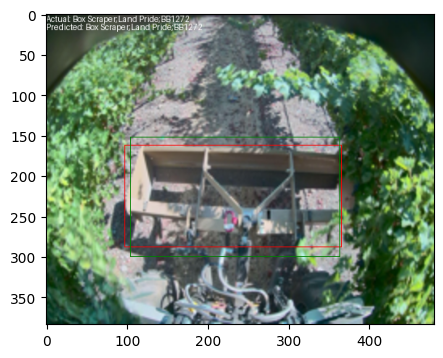

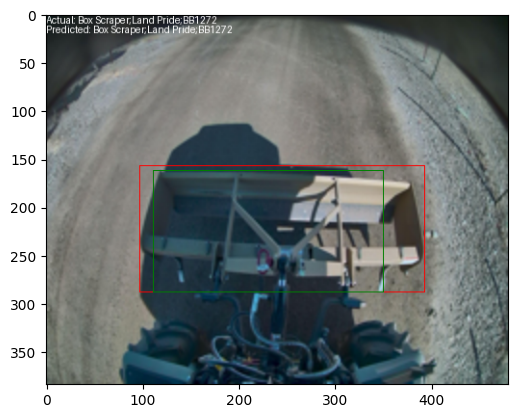

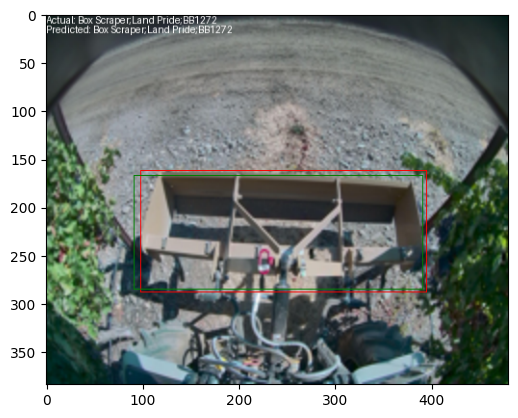

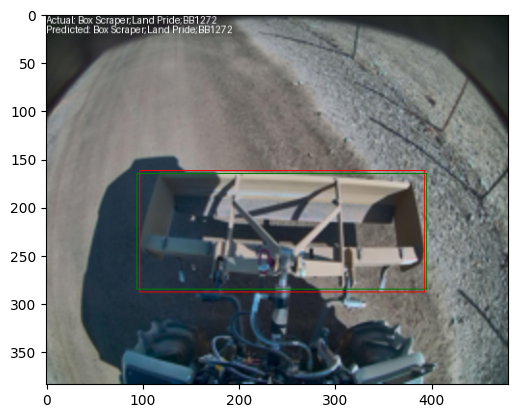

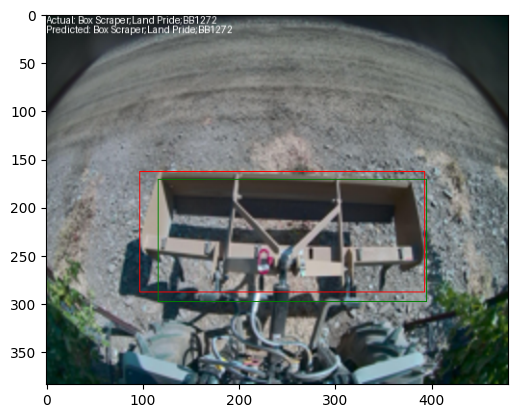

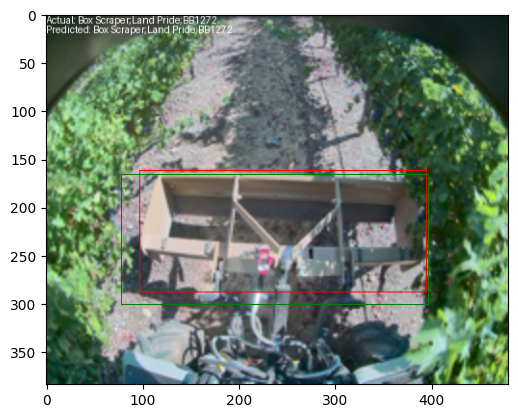

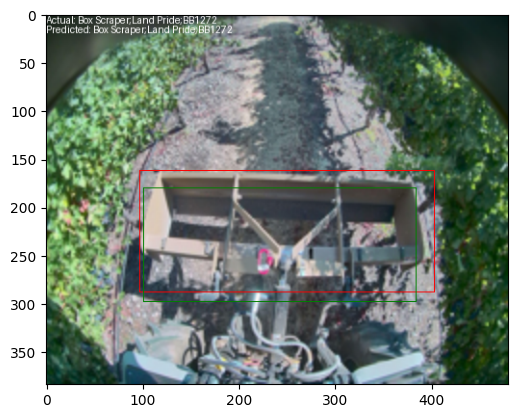

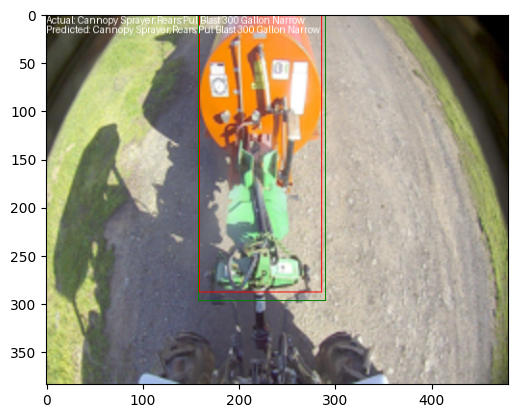

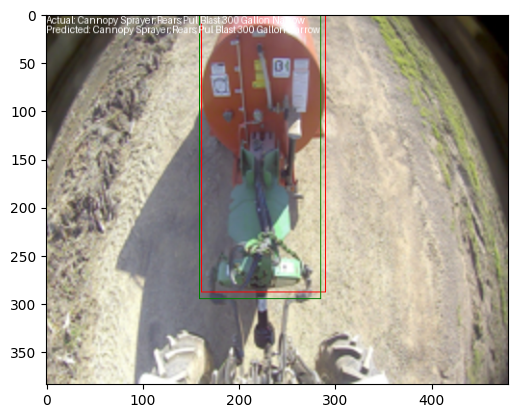

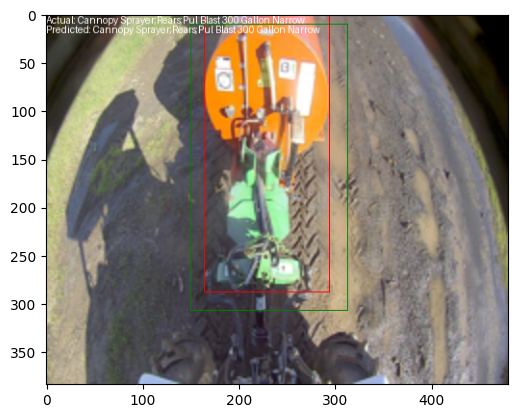

In [11]:
from PIL import ImageDraw


def format_bbox(bbox, size):
    # bbox is [left, right, upper, bottom]
    # return [left, upper, right, bottom] multiplied by image size
    # size is (width, height)
    return bbox[0] * size[0], bbox[2] * size[1], bbox[1] * size[0], bbox[3] * size[1]

def plot_test_image_predictions(model, test_dl, device='cuda', dtype=torch.bfloat16, max_images = 10):
    model.eval()
    num_plotted = 0
    with torch.no_grad():
        fig, ax = plt.subplots(1,1,figsize=(5,5))
        for data in test_dl:
            # data is a dict of [images, implement_class, left, right, upper, bottom]
            images = data['image'].to(device=device, dtype=dtype)
            implement_class = data['implement_class'].to(device=device, dtype=torch.long)
            bbox = data['bbox'].to(device=device, dtype=dtype)
            pred = model(images)
            pred_class = pred[:, :len(test_dl.dataset.implement_classes)]
            pred_bbox = pred[:, len(test_dl.dataset.implement_classes):]
            pred_class = pred_class.argmax(dim=1)
            pred_bbox = pred_bbox.to(torch.float).cpu().numpy()
            pred_class = pred_class.to(torch.float).cpu().numpy()
            bbox = bbox.to(torch.float).cpu().numpy()
            implement_class = implement_class.cpu().numpy()
            for i in range(len(images)):
                img = images[i].to(torch.float).cpu().numpy().transpose(1,2,0)
                img = (img * 255).astype('uint8')
                img = Image.fromarray(img)
                img = img.resize((IMAGE_SIZE[0]*2, IMAGE_SIZE[1]*2))
                img = img.convert('RGB')
                img = img.copy()
                draw = ImageDraw.Draw(img)
                draw.rectangle(format_bbox(bbox[i],img.size), outline='red')
                draw.rectangle(format_bbox(pred_bbox[i],img.size), outline='green')
                draw.text((0,0), f"Actual: {test_dl.dataset.implement_classes[int(implement_class[i])]}")
                draw.text((0,10), f"Predicted: {test_dl.dataset.implement_classes[int(pred_class[i])]}")
                plt.imshow(img)
                plt.show()
                num_plotted += 1
                if num_plotted >= max_images:
                    return

plot_test_image_predictions(model, test_dl, train_config['device'], dtype)

In [12]:
def inference_on_test_set(model, test_dl, device='cuda', dtype=torch.bfloat16):
    # return class and bbox predictions for each image in test_dl
    model.eval()
    num_classes = len(test_dl.dataset.implement_classes)
    class_preds = []
    bbox_preds = []
    with torch.no_grad():
        for data in tqdm(test_dl):
            # data is a dict of [images, implement_class, left, right, upper, bottom]
            images = data['image'].to(device=device, dtype=dtype)
            pred = model(images)
            pred_class = pred[:, :num_classes]
            pred_bbox = pred[:, num_classes:]
            pred_class = pred_class.argmax(dim=1)
            pred_bbox = pred_bbox.to(torch.float).cpu().numpy()[0].tolist()
            pred_class = pred_class.cpu().numpy()
            bbox_preds.append(pred_bbox)
            class_preds.append(pred_class.item())
    return class_preds, bbox_preds

class_preds, bbox_preds = inference_on_test_set(model, test_dl, train_config['device'], dtype)

100%|██████████| 105/105 [00:01<00:00, 55.99it/s]


In [13]:
pred_bbox_df = pd.DataFrame(bbox_preds, columns=['pred_left', 'pred_right', 'pred_upper', 'pred_bottom'], index=test_df.index)
pred_bbox_df

,pred_left,pred_right,pred_upper,pred_bottom
0,0.216797,0.757812,0.396484,0.781250
1,0.231445,0.730469,0.423828,0.750000
2,0.190430,0.816406,0.435547,0.742188
3,0.197266,0.824219,0.431641,0.742188
4,0.243164,0.824219,0.447266,0.777344
...,...,...,...,...
100,0.076660,0.925781,0.097656,0.765625
101,0.069336,0.921875,0.075684,0.761719
102,0.082520,0.917969,0.089844,0.769531
103,0.083008,0.917969,0.091797,0.769531


In [14]:
def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size

def calc_iou(r:pd.Series):
    # r is a r from eval_df
    # r is [left, right, upper, bottom, pred_left, pred_right, pred_upper, pred_bottom, ground_truth, class_pred]
    # return iou
    gt_area = max(0, (r.right - r.left) * (r.bottom - r.upper))
    pred_area = max(0, (r.pred_right - r.pred_left) * (r.pred_bottom - r.pred_upper))
    intersection_left = max(r.left, r.pred_left)
    intersection_right = min(r.right, r.pred_right)
    intersection_upper = max(r.upper, r.pred_upper)
    intersection_bottom = min(r.bottom, r.pred_bottom)
    intersection_area = max(0, intersection_right - intersection_left) * max(0, intersection_bottom - intersection_upper)
    union_area = gt_area + pred_area - intersection_area

    return intersection_area / union_area


In [15]:
eval_df = test_df.copy()
eval_df['image_size'] = eval_df.image_path.apply(lambda x: get_image_size(x))
eval_df['left'] = eval_df.left / eval_df.image_size.apply(lambda x: x[0])
eval_df['right'] = eval_df.right / eval_df.image_size.apply(lambda x: x[0])
eval_df['upper'] = eval_df.upper / eval_df.image_size.apply(lambda x: x[1])
eval_df['bottom'] = eval_df.bottom / eval_df.image_size.apply(lambda x: x[1])
eval_df['ground_truth'] = eval_df.implement_class.apply(lambda x: train_ds.class_map[x])
eval_df['class_pred'] = class_preds
eval_df = eval_df.merge(pred_bbox_df, left_index=True, right_index=True)
eval_df.drop(columns=['image_path', 'json_path', 'implement_class','image_size'], inplace=True)
eval_df['iou'] = eval_df.apply(calc_iou, axis=1)
eval_df

,left,right,upper,bottom,ground_truth,class_pred,pred_left,pred_right,pred_upper,pred_bottom,iou
0,0.203646,0.760417,0.423828,0.75,0,0,0.216797,0.757812,0.396484,0.781250,0.827293
1,0.203125,0.818750,0.410807,0.75,0,0,0.231445,0.730469,0.423828,0.750000,0.779480
2,0.205208,0.825521,0.421875,0.75,0,0,0.190430,0.816406,0.435547,0.742188,0.900738
3,0.203646,0.819271,0.421224,0.75,0,0,0.197266,0.824219,0.431641,0.742188,0.928418
4,0.203646,0.819271,0.425781,0.75,0,0,0.243164,0.824219,0.447266,0.777344,0.803782
...,...,...,...,...,...,...,...,...,...,...,...
100,0.055208,0.936458,0.085286,0.75,13,13,0.076660,0.925781,0.097656,0.765625,0.924668
101,0.055208,0.943750,0.082031,0.75,13,13,0.069336,0.921875,0.075684,0.761719,0.935212
102,0.061979,0.932292,0.085938,0.75,13,13,0.082520,0.917969,0.089844,0.769531,0.928092
103,0.066667,0.932292,0.087891,0.75,13,13,0.083008,0.917969,0.091797,0.769531,0.932356


84.76%


<Axes: >

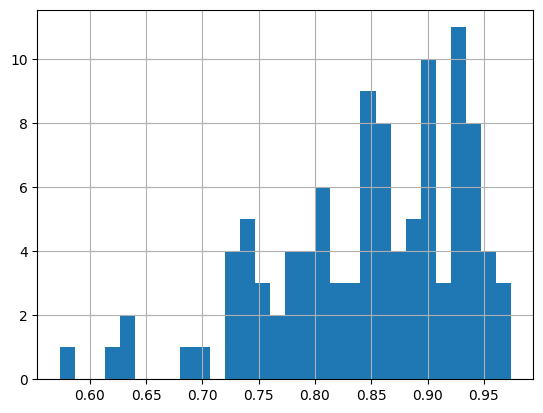

In [16]:
print(f"{eval_df.iou.mean()*100:.2f}%")
eval_df.iou.hist(bins=30)

In [17]:
eval_df.value_counts(['ground_truth','class_pred'])

ground_truth  class_pred
2             2             10
3             3             10
4             4             10
5             5             10
7             7             10
13            13            10
11            11             9
12            12             9
0             0              7
8             8              7
10            10             4
1             1              3
6             6              2
9             9              2
11            12             1
12            11             1
Name: count, dtype: int64